In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.cross_validation import KFold, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics.pairwise import cosine_similarity
from difflib import SequenceMatcher as SM
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.grid_search import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import datetime

%matplotlib inline

In [4]:
def convert_unix_timestamp(df, column_name):
    df[column_name] = df[column_name].map(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y-%m-%d %H:%M:%S'))

In [2]:
def add_dummies(df, column_name, baseline):
    dummies = pd.get_dummies(df[column_name])
    dummies.drop(baseline, axis=1, inplace=True)
    df.drop(column_name, axis=1, inplace=True)
    return pd.concat((df, dummies), axis=1)

In [3]:
def length_of_feature(df, column_name, length_col_name, drop_orig=True):
    df[length_col_name] = map(lambda x: len(x), df[column_name])
    if drop_orig == True:
        df.drop(column_name, axis=1, inplace=True)

In [5]:
def smote(X, y, minority_weight=.5):
    '''
    generates new observations in minority class
    so that output X, y have specified percentage of majority observations
    '''
    # compute number of new examples required
    class_ratio = y.sum()/float(len(y))
    majority_class_label = round(class_ratio)
    X_minority = X[y!=majority_class_label]
    y_minority = y[y!=majority_class_label]
    min_count = len(X_minority)
    maj_count = len(X) - min_count
    scaling_factor = (maj_count/float(min_count))*(minority_weight/(1-minority_weight))
    new_observations_target = round(scaling_factor*min_count) - min_count

    # train KNN
    knn_model = KNeighborsClassifier(n_neighbors=int(round(len(X_minority)**.5)))
    knn_model.fit(X_minority, y_minority)
    if new_observations_target < len(X_minority):
        sample_indices = np.random.choice(xrange(X_minority), 
                                          size=new_observations_target,
                                          replace=False)
        smote_samples = X_minority[sample_indices]
    else:
        smote_samples = X_minority
    neighbors = knn_model.kneighbors(smote_samples)[1]
    
    # generate new samples
    new_observations = np.empty((0,X.shape[1]))
    while len(new_observations) < new_observations_target:
        index = len(new_observations) % len(smote_samples)
        neighbor_index = np.random.choice(neighbors[index])
        neighbor = smote_samples[neighbor_index]
        x = X_minority[index]
        new_x = x + (neighbor - x)*np.random.random(size=X_minority.shape[1])
        new_observations = np.vstack((new_observations, new_x))
    minority_class_label = (majority_class_label + 1) % 2
    X = np.vstack((X, new_observations))
    y = np.hstack((y, np.array([minority_class_label]*len(new_observations))))
    
    return X, y

In [6]:
def feature_importance(model, dfX, dfy):
    fi = model.feature_importances_
    yticks = X.columns[np.argsort(fi)].values
    fi = sorted(fi)
    x = xrange(len(yticks))
    plt.figure(figsize=(15, 15))
    plt.barh(x, fi)
    plt.yticks(x, yticks)
    plt.tight_layout()

## Read in data

In [7]:
df = pd.read_json('train_new.json')

In [8]:
# Find rows that are fraudulent
frauds = df['acct_type'].str.contains('fraudster')

In [9]:
df['fraud'] = frauds

In [46]:
#convert_unix_timestamp(df, 'event_created')
#convert_unix_timestamp(df, 'event_start')
#convert_unix_timestamp(df, 'event_end')
# Filling empty values
#df['event_published'] = df['event_published'].fillna(1352831618)
#convert_unix_timestamp(df, 'event_published')

#convert_unix_timestamp(df, 'user_created')

In [10]:
# Countries dummies ('US' as baseline)
df = add_dummies(df, 'country', 'US')
# Currency dummies ('USD' as baseline)
df = add_dummies(df, 'currency', 'USD')
# Payouts dummies ('ACH' as baseline)
df = add_dummies(df, 'payout_type', 'ACH')

In [56]:
df.head()

,acct_type,approx_payout_date,body_length,channels,delivery_method,email_domain,event_created,event_end,event_published,event_start,...,EUR,GBP,MXN,NZD,,CHECK,len_desc,len_pp,len_org_desc,len_tt
0,fraudster_event,1266062400,3852,5,0,gmail.com,2010-01-05 17:01:46,2010-02-08 04:00:00,2010-01-09 23:50:38,2010-02-07 18:00:00,...,0,0,0,0,1,0,3687,0,0,3
1,premium,1296720000,3499,0,1,ruf.org,2010-12-31 13:57:50,2011-01-29 00:00:00,2010-12-31 14:08:15,2011-01-28 15:00:00,...,0,0,0,0,0,1,3499,49,554,2
2,premium,1296172800,2601,8,1,pvsd.k12.ca.us,2010-11-29 20:22:36,2011-01-22 16:00:00,2010-11-29 20:38:28,2011-01-22 08:30:00,...,0,0,0,0,0,1,2601,36,72,1
3,premium,1388966400,12347,6,1,irishtabletennis.com,2013-02-12 07:06:10,2013-12-31 16:00:00,2013-02-12 07:37:26,2013-02-12 13:00:00,...,1,0,0,0,0,0,12347,21,0,6
4,premium,1297900800,2417,11,0,artsandbusinesscouncil.org,2010-12-10 07:24:26,2011-02-11 16:00:00,2010-12-10 07:29:26,2011-02-11 08:00:00,...,0,0,0,0,0,1,2417,49,389,8


In [11]:
length_of_feature(df, 'description', 'len_desc')
length_of_feature(df, 'previous_payouts', 'len_pp')
length_of_feature(df, 'org_desc', 'len_org_desc')

In [12]:
length_of_feature(df, 'ticket_types', 'len_tt')

In [14]:
df['has_header'] = df['has_header'].fillna(2)
df['venue_latitude'] = df['venue_latitude'].fillna(0.)
df['venue_longitude'] = df['venue_longitude'].fillna(0.)
df['sale_duration'] = df['sale_duration'].fillna(df['sale_duration'].mean())

In [15]:
df['org_facebook'] = df['org_facebook'].fillna(0)
df['org_twitter'] = df['org_twitter'].fillna(0)
df['event_published'] = df['event_published'].fillna(0)
df['delivery_method'] = df['delivery_method'].fillna(0)

In [16]:
df.drop(['venue_state', 'venue_name', 'venue_address'], axis=1, inplace=True)

In [17]:
sus_domains = ["gmail.com", "yahoo.com", "hotmail.com", "ymail.com","aol.com", \
               "lidf.co.uk"," live.com", "live.fr", "yahoo.co.uk", "rocketmail.com"]
df['sus_domain'] = map(lambda x: True if x in sus_domains else False, df['email_domain'])
df.drop(['email_domain'], axis=1, inplace=True)

In [18]:
def fuzzy(x):
    return SM(None, x['org_name'], x['payee_name']).ratio()

df['fuzzy_sim'] = df.apply(fuzzy, axis=1)

In [19]:
df.drop(['name', 'org_name', 'payee_name'], axis=1, inplace=True)

In [20]:
df.drop(['acct_type', 'venue_country'], axis=1, inplace=True)
df['listed'] = df['listed'].map({'y': 1, 'n': 0})

In [21]:
y = df['fraud']
X = df.drop('fraud', axis=1)

In [22]:
X_smoted, y_smoted = smote(X.values, y.values, minority_weight=.3)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Fitting Random Forest

In [25]:
rf = RandomForestClassifier()
rf.fit(X_smoted, y_smoted)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

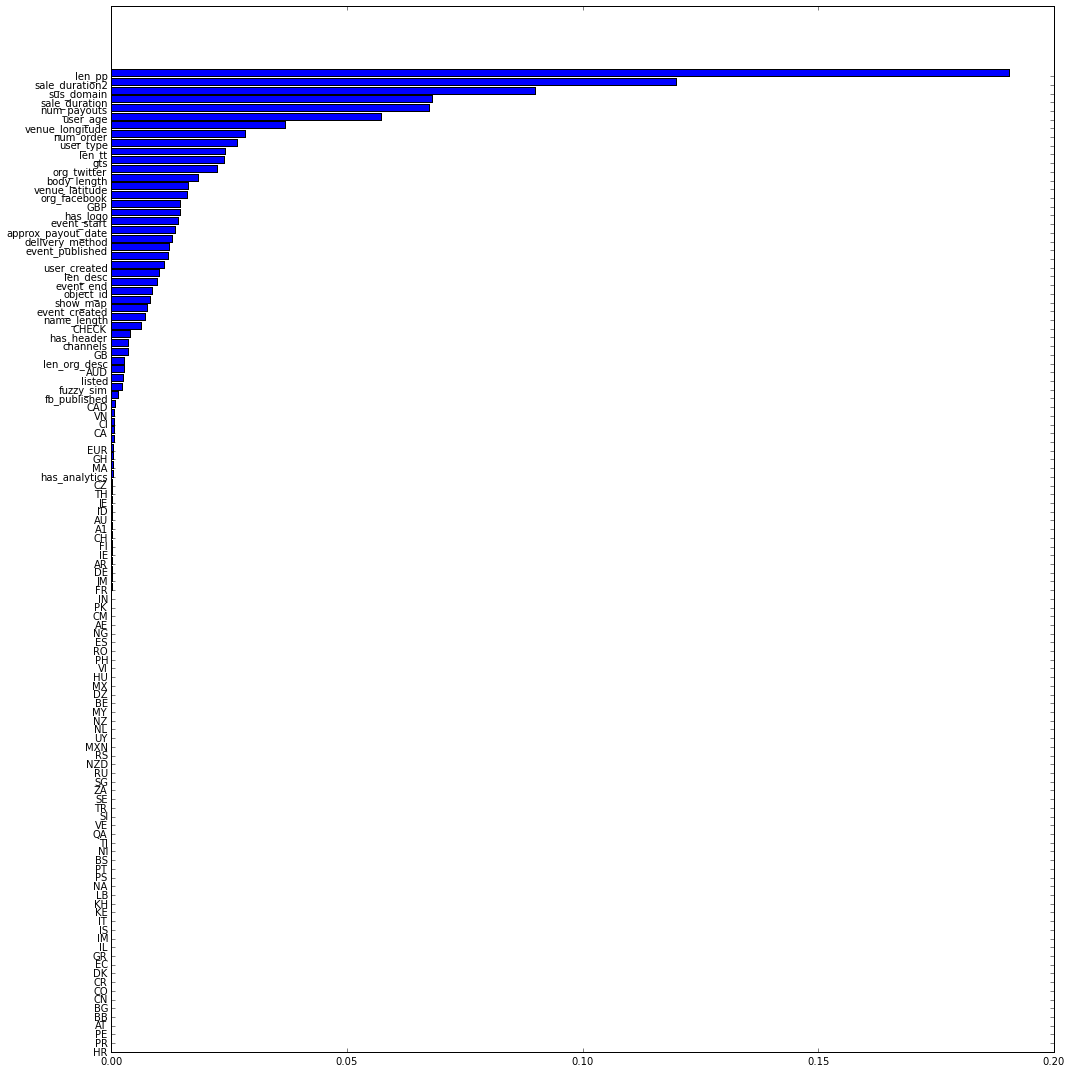

In [112]:
feature_importance(rf, X_smoted, y_smoted)

In [116]:
rf.score(X_smoted, y_smoted)


0.99924868519909837

In [26]:
y_pred = rf.predict(X_test)

In [27]:
confusion_matrix(y_test, y_pred)

array([[2614,    0],
       [   1,  253]])

In [28]:
tpr = 2614. / (2614 + 1)

In [29]:
print "Accuracy Score: ", rf.score(X, y)
print "True Positive Rate: ", tpr

Accuracy Score:  0.99937225361
True Positive Rate:  0.999617590822


### Random Forest on Top 20 Features

In [33]:
yticks = X.columns[np.argsort(rf.feature_importances_)].values
features = yticks[-20:]

In [39]:
X_top = X[features]

In [44]:
X_top_smoted, y_smoted = smote(X_top.values, y.values, minority_weight=.3)

In [46]:
X_top_train, X_top_test, y_train, y_test = train_test_split(X_top, y, test_size=0.20, random_state=42)

In [45]:
rf_top = RandomForestClassifier()
rf_top.fit(X_top_smoted, y_smoted)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [47]:
rf_top.score(X_top_test, y_test)

0.99965132496513254

In [48]:
y_pred = rf_top.predict(X_top_test)

In [53]:
confusion_matrix(y_test, y_pred)

array([[2614,    0],
       [   1,  253]])

## Trying Other Models

In [54]:
# Grid Search on SVM
parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10, 0.1]}
svm = SVC()
gs = GridSearchCV(svm, parameters, scoring='recall')

In [ ]:
gs.fit(X_top_train, y_train)

In [ ]:
# Grid Search on GBR
gradient_boosting_grid = {'learning_rate':[0.01, 0.05, 0.1, 0.5], 
                          'max_depth': [1, 3, 5, 7],
                          'min_samples_leaf': [1, 2, 4, 6],
                          'n_estimators': [20, 100, 200]}
gbr = GradientBoostingClassifier()
gs_gbr = GridSearchCV(gbr, gradient_boosting_grid, scoring='recall')